## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings

In [2]:
df = pd.read_csv("../data/shampoo.csv")

In [3]:
df.head()

,"Month;""Sales"""
0,01-01;266
1,01-02;145.9
2,01-03;183.1
3,01-04;119.3
4,01-05;180.3


## Data Preparation

In [4]:
df["Month"] = df['Month;"Sales"'].str.slice(0,5)

In [5]:
df["Month"] = pd.to_datetime(df['Month'], format='%y-%m')

In [6]:
df["Sales"] = df['Month;"Sales"'].str.slice(6,)

In [7]:
df.set_index('Month',inplace=True)

In [8]:
df.drop(columns=['Month;"Sales"'],inplace=True)

In [9]:
df.head()

,Sales
Month,
2001-01-01,266
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2001-01-01 to 2003-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Sales   36 non-null     object
dtypes: object(1)
memory usage: 576.0+ bytes


In [11]:
df['Sales']=df['Sales'].astype(float)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2001-01-01 to 2003-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   36 non-null     float64
dtypes: float64(1)
memory usage: 576.0 bytes


## Data Visualization

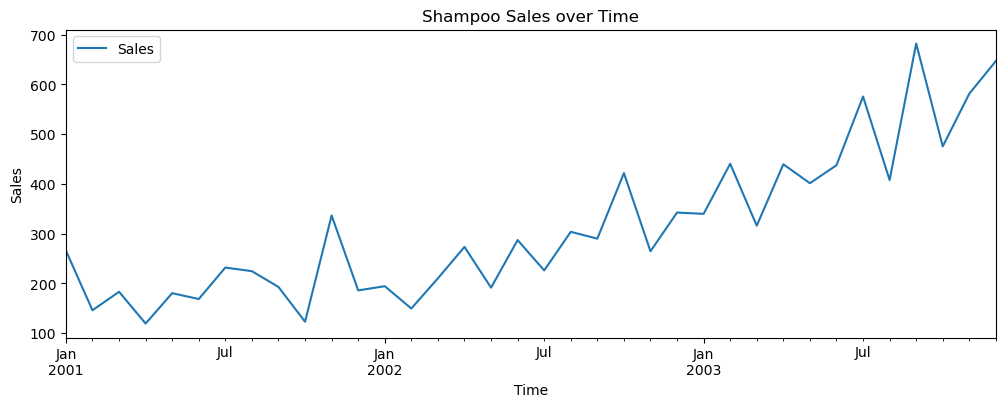

In [13]:
df.plot(figsize=(12,4))
plt.ylabel('Sales')
plt.title("Shampoo Sales over Time")
plt.xlabel('Time')
plt.show()

#### Decomposition

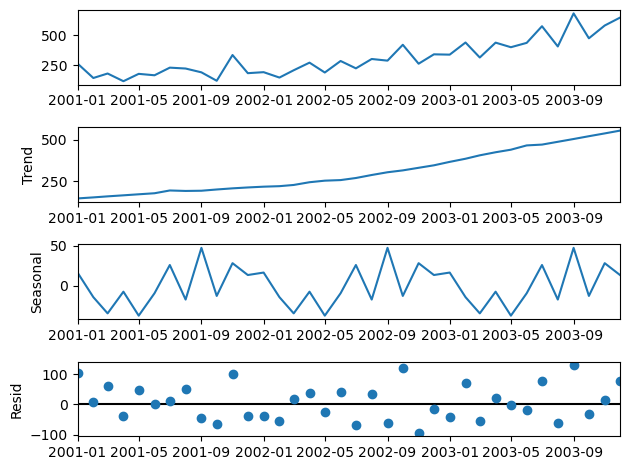

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df,model='additive',extrapolate_trend='freq').plot()

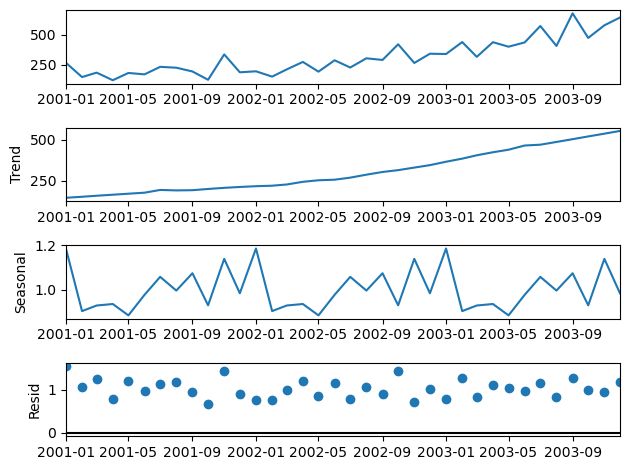

In [15]:
decomposition = seasonal_decompose(df,model='multiplicative',extrapolate_trend='freq')
decomposition.plot()
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

In the multiplicative model, We observe that the trend and seasonality are clearly separated and the scale of noise is small. In the additive model, there are outliers present in the residual. So the series is multiplicative.

# Differencing

In [16]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Sales'])

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [17]:
adfuller_test(df['Sales'])

ADF Test Statistic : 3.0601420836411815
p-value : 1.0
#Lags Used : 10
Number of Observations Used : 25
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


We will have to difference data to make it stationary

c:\Users\sriva\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


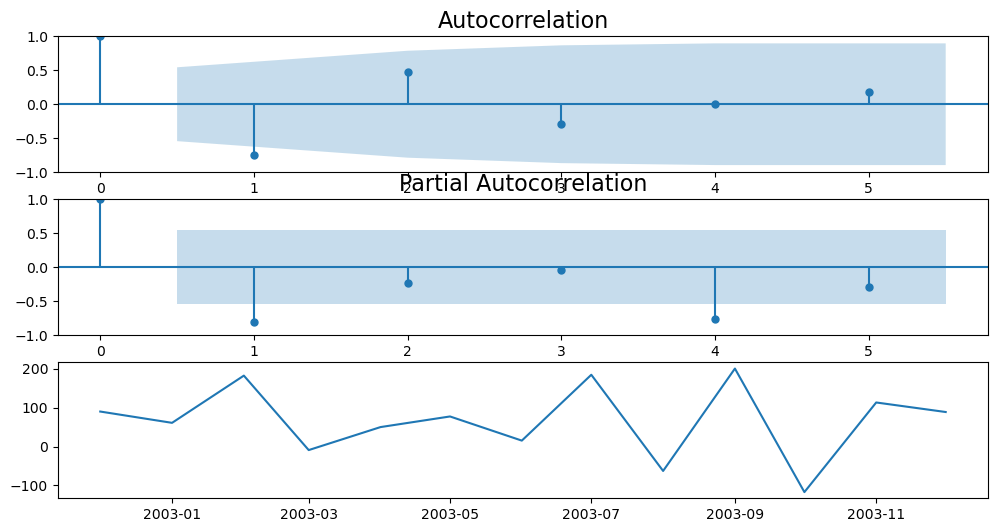

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Stationary data
df['station'] = df.Sales - df.Sales.rolling(12).mean()

fig, ax = plt.subplots(3, figsize=(12,6))
x = (df.station.dropna() - df.station.dropna().shift(12)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=5)
ax[1] = plot_pacf(x, ax=ax[1], lags=5)
ax[2].plot(x)

In [19]:
adfuller_test(df['station'].dropna())

ADF Test Statistic : -5.080710065661428
p-value : 1.5326629924655042e-05
#Lags Used : 0
Number of Observations Used : 24
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


### Train Test Split

In [20]:
i=0.75
per=df.shape[0]*i
per

27.0

In [21]:
train = df.iloc[:int(per+1)]
test = df.iloc[int(per+1):]

In [22]:
print(train.shape[0])
train.tail()

28


,Sales,station
Month,,
2002-12-01,342.3,79.508333
2003-01-01,339.7,64.791667
2003-02-01,440.4,141.250000
2003-03-01,315.9,7.933333
2003-04-01,439.3,117.500000


In [23]:
print(test.shape[0])
test.head()

8


,Sales,station
Month,,
2003-05-01,401.3,62.008333
2003-06-01,437.4,85.575000
2003-07-01,575.5,194.550000
2003-08-01,407.6,17.983333
2003-09-01,682.0,259.708333


### Sarimax

### Predict P,Q

In [37]:
import itertools
P=range(0,6)
D=range(1,2)
Q=range(0,6)

pdq_combination=list(itertools.product(P,D,Q))

In [38]:
len(pdq_combination)

36

In [39]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [40]:
order1=[]
rmse=[]

for pdq in pdq_combination:
    try:
        model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(2, 1, 3),seasonal_order=(pdq[0],pdq[1],pdq[2],12)).fit()
        pred=model.predict(start='2003-05-01',end='2003-12-01',dynamic=True)
        error=np.sqrt(mean_squared_error(test['Sales'],pred))
        order1.append(pdq)
        rmse.append(error)
    except Exception as e:
        raise e

results=pd.DataFrame(index=order1,data=rmse,columns=['RMSE']).sort_values('RMSE')
results.head(10)

,RMSE
"(4, 1, 1)",63.761100
"(3, 1, 1)",63.798622
"(5, 1, 4)",64.291485
"(5, 1, 2)",64.653805
"(4, 1, 2)",64.808255
"(3, 1, 0)",64.962202
"(5, 1, 0)",65.291275
"(4, 1, 3)",65.343049
"(3, 1, 2)",66.105335
"(4, 1, 0)",66.406248


In [41]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(2, 1, 3),seasonal_order=(4,1,1,12)).fit()

In [51]:
predicted_SARIMA = model.forecast(steps=24)
predicted_SARIMA

2004-01-01     585.878137
2004-02-01     617.802571
2004-03-01     552.853866
2004-04-01     730.586277
2004-05-01     665.939500
2004-06-01     715.496623
2004-07-01     768.457410
2004-08-01     655.050443
2004-09-01     961.721201
2004-10-01     861.026434
2004-11-01     763.093791
2004-12-01     879.665271
2005-01-01     910.173343
2005-02-01     975.420533
2005-03-01     826.705805
2005-04-01     975.554351
2005-05-01     981.842486
2005-06-01     971.310535
2005-07-01    1156.793515
2005-08-01     907.247767
2005-09-01    1319.851306
2005-10-01    1007.971009
2005-11-01    1158.271392
2005-12-01    1197.171758
Freq: MS, Name: predicted_mean, dtype: float64

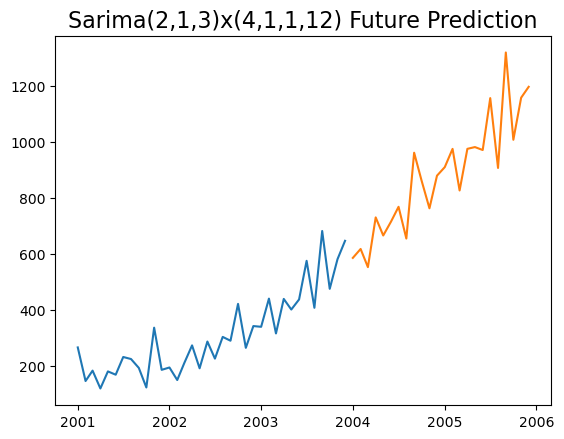

In [52]:
plt.plot(df['Sales'],label='Actual data')
plt.plot(predicted_SARIMA,label='Predicted Data - ARIMA')
plt.grid()
plt.title('Sarima(2,1,3)x(4,1,1,12) Future Prediction')
plt.grid()

## Evaluation 

In [53]:
error=np.sqrt(mean_squared_error(test['Sales'],model.predict(start='2003-05-01',end='2003-12-01')))
print("Root mean squared error",error)

Root mean squared error 78.15004116030478


<AxesSubplot:xlabel='Month'>

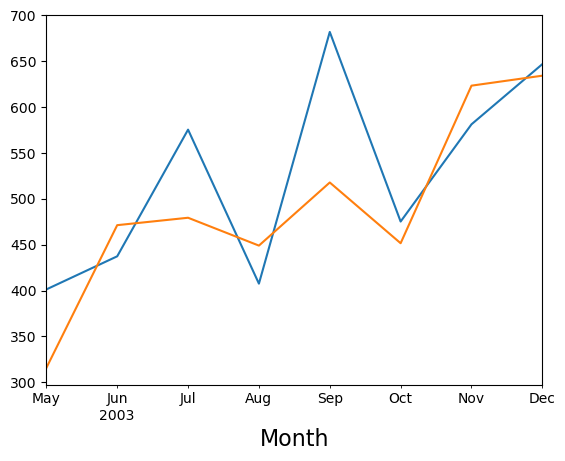

In [55]:
test['Sales'].plot()
model.predict(start='2003-05-01',end='2003-12-01').plot()